## Training a Convolutional Neural Network on the MINST dataset.

### import all necessary python modules

In [2]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np # linear algebra
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### set hyperparameters and get training and testing data formatted

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### build the model and take a look at the model summary

In [4]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### compile and train/fit the model


In [5]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 12s 204us/step - loss: 0.2536 - acc: 0.9221 - val_loss: 0.0573 - val_acc: 0.9805
Epoch 2/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0837 - acc: 0.9750 - val_loss: 0.0417 - val_acc: 0.9860
Epoch 3/12
29184/60000 [=============>................] - ETA: 4s - loss: 0.0668 - acc: 0.9805

60000/60000 [==============================] - 10s 166us/step - loss: 0.0637 - acc: 0.9810 - val_loss: 0.0344 - val_acc: 0.9887
Epoch 4/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0518 - acc: 0.9844 - val_loss: 0.0342 - val_acc: 0.9885
Epoch 5/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0461 - acc: 0.9862 - val_loss: 0.0299 - val_acc: 0.9895
Epoch 6/12
  512/60000 [..............................] - ETA: 9s - loss: 0.0306 - acc: 0.9863 

60000/60000 [==============================] - 10s 166us/step - loss: 0.0403 - acc: 0.9876 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 7/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0355 - acc: 0.9887 - val_loss: 0.0282 - val_acc: 0.9916
Epoch 8/12
55040/60000 [==========================>...] - ETA: 0s - loss: 0.0337 - acc: 0.9899

60000/60000 [==============================] - 10s 166us/step - loss: 0.0335 - acc: 0.9901 - val_loss: 0.0312 - val_acc: 0.9897
Epoch 9/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0320 - acc: 0.9904 - val_loss: 0.0276 - val_acc: 0.9906
Epoch 10/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0296 - acc: 0.9912 - val_loss: 0.0280 - val_acc: 0.9909
Epoch 11/12
 4736/60000 [=>............................] - ETA: 8s - loss: 0.0267 - acc: 0.9922

60000/60000 [==============================] - 10s 166us/step - loss: 0.0281 - acc: 0.9920 - val_loss: 0.0258 - val_acc: 0.9911
Epoch 12/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0258 - acc: 0.9919 - val_loss: 0.0251 - val_acc: 0.9921


### evaluate the model on the testing dataset

In [6]:
score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 122us/step
Test loss: 0.02509016195321419
Test accuracy: 0.9921


### compare predictions to the input data

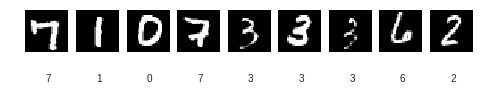

In [9]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 9
rows = 1
indices = np.random.randint(len(x_test), size=(10))
labels = np.argmax(model.predict(x_test[indices]), axis=1)
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[indices[i-1]].reshape((28, 28)), cmap = 'gray')
    plt.axis('off')
    plt.text(15,45, labels[i-1],  horizontalalignment='center', verticalalignment='center')
plt.show()

### code that will allow us to visualize the convolutional filters

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))
        ax[x, y].set_axis_off()
        
    #plt.axis('off')

### convolutional filters for the first element in the training dataset for the first convolutional layer

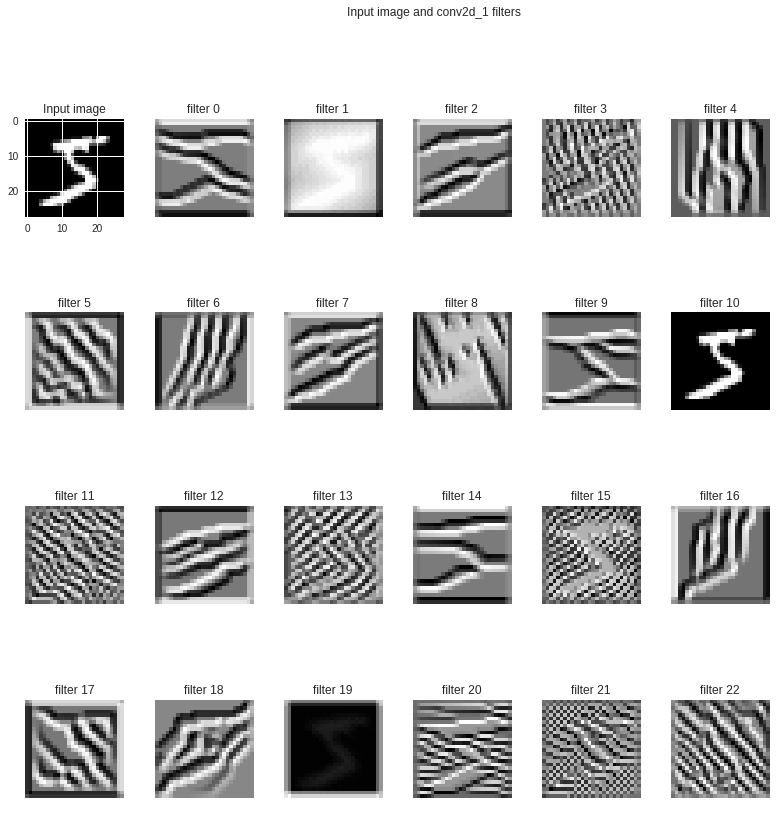

In [29]:
vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), layer_name = 'conv2d_1')

### convolutional filters for the first element in the training dataset for the second convolutional layer

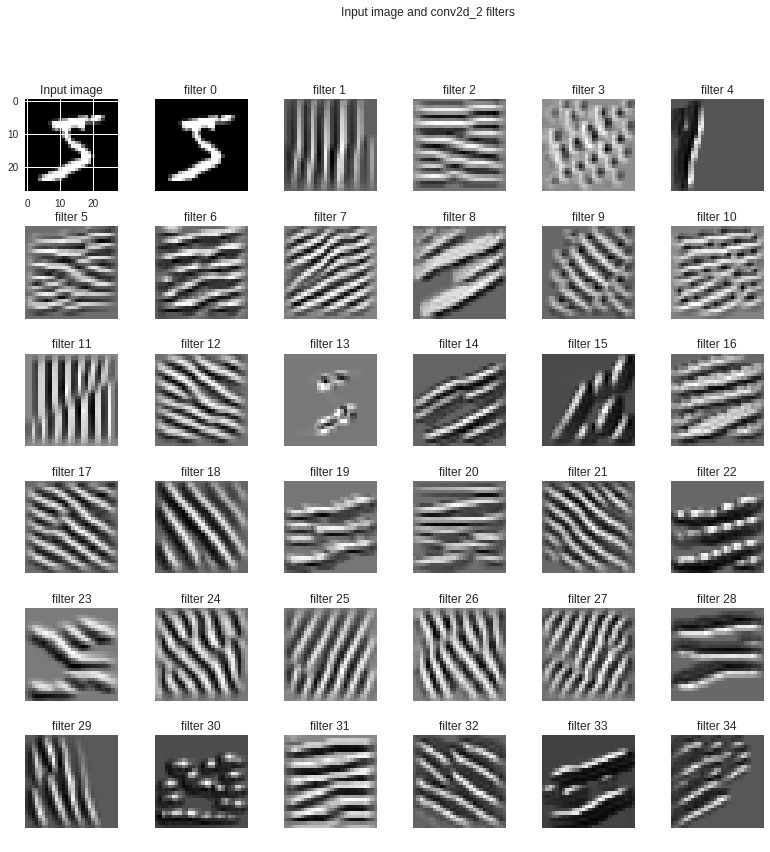

In [27]:
vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), layer_name = 'conv2d_2')